<a href="https://colab.research.google.com/github/rhobaker/Data_Project/blob/main/Main_Jupyter_workbook_Rhona.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Import all libraries needed for the project
import requests as requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests as requests
from functools import reduce

# Introduction to the project

>> Need to choose a colour palette that will work for the whole workbook

The aim of our project was to examine the evidence that a proposed bill being put before the UK Parliament will be effective in reducing smoking rates in the UK.

The long title of this bill is:

> A Bill to Make provision about the supply of tobacco, vapes and other products, including provision prohibiting the sale of tobacco to people born on or after 1 January 2009; and to enable product requirements to be imposed in connection with tobacco, vapes and other products.

https://bills.parliament.uk/bills/3703

The Bill will prohibit the sale of cigarettes to people born after 2008.  Each year the age at which people can legally buy cigarettes will increase, resulting in people born after 31st December 2008 never being able to buy them.  This will be enforced by fining organisations who break the law.  The government believes that this will reduce the harm caused by smoking, which is still the number one cause of preventable deaths in the UK and costs the NHS £17bn a year.


https://www.bbc.co.uk/news/health-68825322#:~:text=The%20restrictions%20will%20apply%20to,able%20to%20legally%20buy%20cigarettes.



To analyse how effective this ban might be we used evidence from a number of data sources to answer two questions:

**<span style="color:darkblue">Question One:</span>**\
**How effective does historic data suggest that government mitigations have been on affecting smoking prevalence?**

**<span style="color:darkblue">Question Two:</span>**\
**Based on this analysis, how effective will the new ban be on reducing smoking prevalence?**



## <span style="color:darkblue"> Question One: </span>
### **How effective does historic data suggest that government mitigations have been on affecting smoking prevalence?**

### Analysis One:  Changes in global smoking rates compared to levels of government intervention

Using data from the WHO we have analysed how effective government measures have been on reducing rates of smoking globally, in order to determine how effective government measures are in general at reducing smoking rates.


The WHO adopted the WHO Framework Convention on Tobacco Control on 21 May 2003 as a response to the global tobacco epidemic.  It uses the MPOWER package to help countries reduce their smoking rates by reducing the demand for tobacco products from their population.  It has six different strands:


- **M**: Monitor tobacco use and prevention policies
- **P**: Protect people from tobacco smoke
- **O**: Offer help to quit tobacco use
- **W**: Warn about the dangers of tobacco
- **E**: Enforce bans on tobacco advertising, promotion and sponsorship
- **R**: Raise taxes on tobacco

Reference: https://www.who.int/initiatives/mpower

#### Data Analysis

The WHO categorises each of these strands into 5 levels to based on how well they have been implemented in each country, with 1 being the lowest level of control and 5 being the greatest.  This data is publically avaliable via an API.

We used this API to get a total score per country for each of the years it is available.  This was used to calculate a weighted mean level of implementation for the world as a whole, based on the population of each country.

By comparing this to global smoking rates, also avaliable via an API, we prepared an analysis to see if there is a relationship between the adoption of these initiatives and the global smoking rate.

Reference: https://www.who.int/data/gho/data/themes/topics/indicator-groups/indicator-group-details/GHO/tobacco-control---progress-towards-selected-tobacco-control-policies-for-demand-reduction

In [ ]:
# Get all API data needed from the WHO and save as JSON files

# Define the urls for each of the APIs needed:
# Global smoking rates by year:
url_sr = "https://ghoapi.azureedge.net/api/M_Est_tob_curr_std?$filter=SpatialDimType%20eq%20%27GLOBAL%27"
# Levels of smoking intervention prevelance:
urlM = "https://ghoapi.azureedge.net/api/M_Group"
urlP = "https://ghoapi.azureedge.net/api/P_Group"
urlO = "https://ghoapi.azureedge.net/api/O_Group"
urlW = "https://ghoapi.azureedge.net/api/W_Group"
urlE = "https://ghoapi.azureedge.net/api/E_Group"
urlR = "https://ghoapi.azureedge.net/api/R_Group"
# World population by country:
urlpop = "https://ghoapi.azureedge.net/api/RS_1845"

#Use request module to get the API data and save in a variable:
response_sr = requests.get(url_sr)
responseM = requests.get(urlM)
responseP = requests.get(urlP)
responseO = requests.get(urlO)
responseW = requests.get(urlW)
responseE = requests.get(urlE)
responseR = requests.get(urlR)
responsepop = requests.get(urlpop)

#Turn response into JSON data:
json_data_rate = response_sr.json()
json_data_M = responseM.json()
json_data_P = responseP.json()
json_data_O = responseO.json()
json_data_W = responseW.json()
json_data_E = responseE.json()
json_data_R = responseR.json()
json_data_pop = responsepop.json()

#Check that the data has been imported and give an error message if not:
if response_sr.status_code == 200 & responseM.status_code == 200 & responseP.status_code == 200 & responseP.status_code == 200 & responseO.status_code == 200 & responseW.status_code == 200 & responseE.status_code == 200 & responseR.status_code == 200 & responsepop.status_code == 200:
    print("Data was retrieved")
else:
    print("There was an error retrieving the data")

Data was retrieved


In [ ]:
# Create a panda's DataFrame for global smoking rates:

# Set empty arrays to append data into:
sr_value = [] # For rates
sr_time = [] # For years

# Loop through the API data and append data to the empty arrays
for i in json_data_rate["value"]:
    if i["Dim1"] == "SEX_BTSX":  # Data for both sexes together
        sr_value.append(i["NumericValue"])
        sr_time.append(i['TimeDimensionValue'])

# Create lists for the data and for the column labels needed in the DataFrame
data = list(zip(sr_time, sr_value))
label = ["Year", "Smoking Rate"]

#Create the DataFrame
df_rate = pd.DataFrame(data, columns = label)
# Turn the data into numeric values for calculations to be performed and graphs produced
df_rate = df_rate.apply(pd.to_numeric, errors='coerce')
# Set the year as the DataFrame's index
df_rate = df_rate.set_index("Year")
# Check the result
df_rate

,Smoking Rate
Year,
2007,28.1
2000,32.7
2030,18.1
2005,29.3
2021,21.3
2010,26.4
2022,20.9
2018,22.5
2015,23.9


In [ ]:
# Create a panda's DataFrame for population data:

# Set empty arrays to append data into
indexpop = [] # For the country code
valuepop = [] # For the population

# Loop through API data and append values to the empty arrays
for i in json_data_pop["value"]:
    indexpop.append(i["SpatialDim"])
    valuepop.append(i["Value"])

# Create lists for the data and for the column labels needed in the DataFrame
data = list(zip(indexpop, valuepop))
label = ["Code", "Population"]

# Create the DataFrame
df_pop = pd.DataFrame(data, columns = label)

# Clean the spaces out of the numerical data in order to be able to use it for a calculation
df_pop['Population'] = df_pop['Population'].str.replace(' ', '')

# Turn the population value into an integer so it can be used for a calculation
df_pop["Population"] = pd.to_numeric(df_pop["Population"])

# Set the Code column to the DataFrame index
df_pop = df_pop.set_index("Code")
# Check the result
# df_pop

In [ ]:
# Calculate the total global population and save in a variable for use in the weighted mean calculation
total_pop = sum(df_pop["Population"])
total_pop

6787737744

In [ ]:
# Create a panda's DataFrame for MPOWER data:

# Set empty arrays to append data into:
mpower_index = [] # For the country code
mpower_time = [] # For the year
mpower_value = [] # For the value

# Create a list of all files to append data for:
List_of_json = [json_data_M, json_data_P, json_data_O, json_data_W, json_data_E, json_data_R]

for i in List_of_json:
    for j in i["value"]:
        mpower_index.append(j["SpatialDim"])
        mpower_time.append(j["TimeDimensionValue"])
        mpower_value.append(j["Value"])

# Create lists for the data and for the column labels needed in the DataFrame
data = list(zip(mpower_index, mpower_time, mpower_value))
label = ["Code", "Year", "Value"]

# Create the DataFrame
df_MPOWER = pd.DataFrame(data, columns = label)
# Replace "Not applicable" with 1 - the lowest level possible
df_MPOWER = df_MPOWER.replace("Not applicable", 1)

# Turn column "Value" into numeric to be able to calculate the mean
df_MPOWER["Value"] = df_MPOWER["Value"].apply(pd.to_numeric, errors='coerce')

# Create a DataFrame of a pivot table to get the total MPOWER score for each country
df_MPOWER_pivot = pd.DataFrame(df_MPOWER.pivot_table(values='Value', index="Code", columns = "Year", aggfunc = np.sum))
# Check the result
# df_MPOWER_pivot


In [ ]:
# Merge pivot tables with population
# Inner merge used in order to only have data where there is a poplulation number
merged_dataframe = pd.merge(df_pop, df_MPOWER_pivot, left_index=True, right_index=True, how='inner')
# merged_dataframe

In [ ]:
# Multiply population by MPOWER score for the weighted mean calculation:

# Create a list of the years
df_MPOWER_pivot_columns = list(df_MPOWER_pivot.columns)

# Loop through the columns and multiply population by total MPOWER score
for i in df_MPOWER_pivot_columns:
    merged_dataframe[i] = merged_dataframe[i] * merged_dataframe["Population"]
# merged_dataframe

In [ ]:
# Add up each column in the table

# Set empty arrays to append data into:
total_year = []
total_mean = []

# Loop through the and append the weighted mean to the empty arrays
for i in df_MPOWER_pivot_columns:
    total_year.append(i)
    total_mean.append(merged_dataframe[i].sum()/total_pop)

# Create lists for the data needed in the DataFrame
data = list(zip(total_year, total_mean))

# Create a DataFrame of the weighted mean by year
mean_by_year = pd.DataFrame(data, columns = ["Year", "Weighted Mean MPOWER"])
# Turn all data into numeric values in order to plot them on the graph
mean_by_year = mean_by_year.apply(pd.to_numeric, errors='coerce')
# Set year as the index to merge with smoking rates
mean_by_year = mean_by_year.set_index("Year")
# Check the DataFrame
# mean_by_year

In [ ]:
# Merge weighted mean with smoking rate
# Use outer merge as we want to plot data for all of the years
merged_rate_MPOWER = pd.merge(mean_by_year, df_rate, left_index=True, right_index=True, how='outer')
# Drop future years and past years without MPOWER data
cleaned_merged_rate_MPOWER = merged_rate_MPOWER.drop([2000, 2005,2025, 2030])
# Check result
# cleaned_merged_rate_MPOWER

#### Calculate the Correlation

In [ ]:
# Calculate the correlation
print(merged_rate_MPOWER.corr())

                      Weighted Mean MPOWER  Smoking Rate
Weighted Mean MPOWER              1.000000     -0.963532
Smoking Rate                     -0.963532      1.000000


#### Plot the relationship

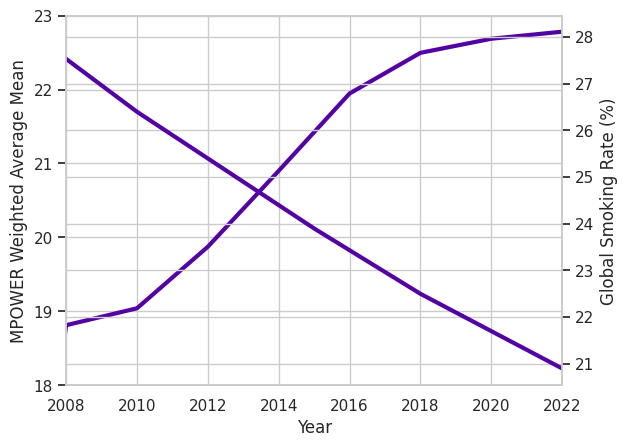

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create a mask to smooth the data into a line as not all years have data
ratemask = np.isfinite(cleaned_merged_rate_MPOWER["Smoking Rate"])
MPOWERmask = np.isfinite(cleaned_merged_rate_MPOWER["Weighted Mean MPOWER"])

# Create the plot and set the axis values
sns.set_theme(style="whitegrid", palette="plasma")
fig, ax1 = plt.subplots()
plt.xlim(2008, 2022)
plt.ylim(18, 23)

# Plot the MPOWER values
ax1.set_xlabel('Year')
ax1.set_ylabel('MPOWER Weighted Average Mean')
ax1.plot(cleaned_merged_rate_MPOWER["Weighted Mean MPOWER"][MPOWERmask], lw = 3)
ax1.tick_params(axis ='y')


# Adding Twin Axes to plot smoking rates
ax2 = ax1.twinx()
ax2.set_ylabel('Global Smoking Rate (%)')
ax2.plot(cleaned_merged_rate_MPOWER["Smoking Rate"][ratemask], lw=3)
ax2.tick_params(axis ='y')

# Adding title
# plt.title('MPOWER Measures and Smoking Rates over Time')

# Show plot
plt.show()
plt.clf()

>> Need to work out how to add figure numbers to these, so we can refer to them through the notebook.

#### Conclusion
The data shows that there is a clear correlation globally between the number of measures in place to reduce demand for tobacco and the smoking rate.
This demonstrates that there is evidence that increasing the measures in place to reduce demand for tobacco products reduces smoking rates.

### Analysis One: How have smoking rates changed in the UK

The next step in our analysis was to determine if this global trend was also seen in the UK.
Over the last twenty years there has been increasing legal measures implemented by successive UK governments to reduce the rate of smoking.
A summary of these measures are outlined below:

#### Timeline of key government legislation and regulation

<img src="https://github.com/rhobaker/Data_Project/blob/main/Smoking_actions_timeline.png?raw=true" width="900" height="450"/>

>> Add figure number

Reference: https://news.cancerresearchuk.org/2023/03/07/ending-smoking-could-free-up-gp-appointments/

### Analysis One:  Changes in UK smoking rates

Our first task was to examine how the UK smoking rate has changed overtime, so it could be compared to other factors.
To do this we took data from the ONS Smoking Habits in the UK dataset.  We restricted this to the years from 2000 to 2019 as these are the years when the majority of government intervention has been seen.

In [ ]:
url = ("https://raw.githubusercontent.com/rhobaker/Data_Project/main/ONS_adult_smoking_habits_in_great_britain/Table_1a-Table_1_cleaned.csv")
smokers = pd.read_csv(url)
smokers.drop(['Unnamed: 0'], axis=1, inplace=True)
#Getting relevant columns for visualisation
adults=smokers[["Year", "All 16+"]]
#Reversing the columns so that both datasets match
adults_reversed = adults.iloc[::-1]
adults_reversed
#Further qualifying the data so only data from the years 2000 is selected
adults_2000 = adults_reversed.iloc[13:33]
adults_2000 = adults_2000.reset_index()
adults_2000.drop(['index'], axis=1, inplace=True)
adults_2000.set_index("Year", inplace = True)
adults_2000.rename(columns={"All 16+": 'Smoking Rate'}, inplace=True)
# adults_2000

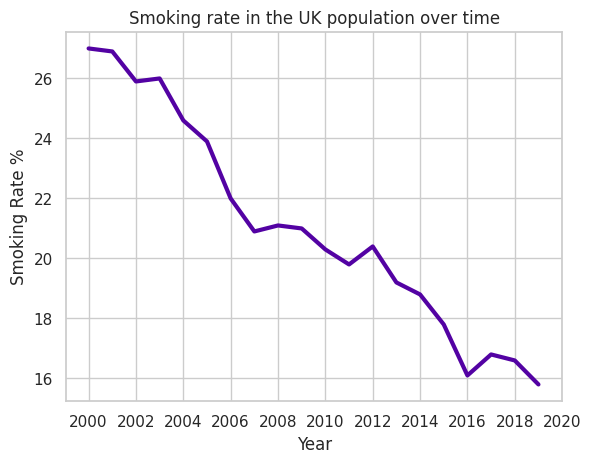

<Figure size 640x480 with 0 Axes>

In [ ]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid", palette="plasma")

plt.figure()
plt.plot(adults_2000["Smoking Rate"], lw=3)
plt.xticks([2000,2002,2004,2006,2008,2010,2012, 2014, 2016, 2018, 2020])
plt.xlabel("Year")
plt.ylabel("Smoking Rate %")
plt.title("Smoking rate in the UK population over time")
plt.show()
plt.clf()

It can be seen that the smoking rate has decreased from over 25% of the population in 2000 to just under 16% in 2019.  This has co-incided with the increase in legistation as described in Figure XX.  This is a reduction of around (58.89m x 27%) 15.9 million people in 2000 to (66.80m x 15.8%) around 10.6 million people in 2019, a fall of around 5.3 million people.

Ref: https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatestimeseriesdataset

Our next step was to analyse what factors may be involved in this decline, in order to predict how any future changes may impact on this trend in the smoking rate.

## Analysis Three: The effect of taxation levels on the smoking rate

One of the ways in which governments have attempted to reduce smoking rates is through raising taxes on tobacco.\
The analysis below shows how the percentage of the cost of a packet of cigarettes that is made up by tax has increased in recent years.

In [ ]:
UK_tax_URL = "https://raw.githubusercontent.com/rhobaker/Data_Project/main/Cleaned_Data/UK_tax_rates_WHO.csv"
full_data = pd.read_csv(UK_tax_URL)
UK_tax_rates = full_data[["Period", "Value"]]
UK_tax_rates = UK_tax_rates.sort_values("Period", ascending = True)
# UK_tax_rates

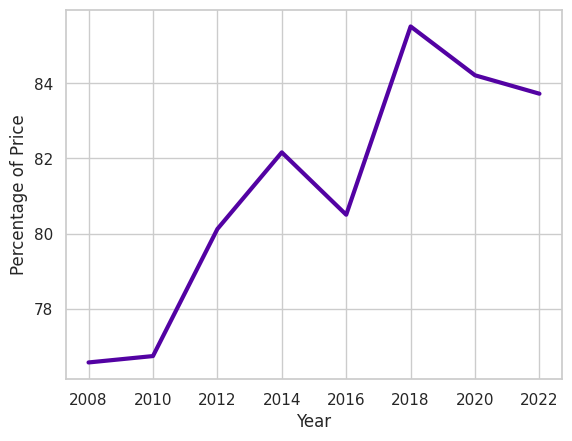

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the data
sns.set_theme(style="whitegrid", palette="plasma")
plt.figure()
plt.plot(UK_tax_rates["Period"],UK_tax_rates["Value"], lw=3)
plt.xticks([2008,2010,2012, 2014, 2016, 2018, 2020, 2022])
plt.ylabel('Percentage of Price')
plt.xlabel('Year')
plt.show()
plt.clf()

It is clear therefore that the UK government has been increasing the amount of tax applied to cigarettes in recent years.

To understand how this has impacted on the price of a packet of cigarettes we then analysed the amount of duty paid on 20 cigarettes from 2000 to 2022.

In [ ]:
# Load the CSV files
pre_may_2017_df = pd.read_csv('https://raw.githubusercontent.com/rhobaker/Data_Project/main/Historical%20Tobacco%20Duty%20rates/clean_historical_tobacco_duty_pre_may_2017.csv')
post_may_2017_df = pd.read_csv('https://raw.githubusercontent.com/rhobaker/Data_Project/main/Historical%20Tobacco%20Duty%20rates/clean_historical_tobacco_duty_post_may_2017.csv')

In [ ]:
price_url = 'https://raw.githubusercontent.com/rhobaker/Data_Project/main/ONS_av_price_cigarettes_king_size_filter/Cleaned_ONS_av_price_cigarettes_king_size_filterce_cigarettes_king_size.csv'
price = pd.read_csv(price_url)

In [ ]:
vat_url = 'https://raw.githubusercontent.com/rhobaker/Data_Project/main/Historical%20Tobacco%20Duty%20rates/IFS%20historic%20VAT%20-%20Sheet1.csv'
vat = pd.read_csv(vat_url)

In [ ]:
# Drop columns no longer needed
vat = vat.drop(columns=['Reducedb', 'Highera', 'Registration threshold']).reset_index()

In [ ]:
# Extract the first year from the 'Year' column and convert to integer
vat['Start Year'] = vat['Year'].str.split('-').str[0].astype(int)
vat = vat[vat['Start Year'] >= 2000].reset_index()
vat = vat.drop(columns=['index', 'level_0'])

In [ ]:
# Strip the last character from the 'standard' column at index 8 and 9
for index in [8, 9]:
    if vat.at[index, 'Standard'].endswith('f'):
        vat.at[index, 'Standard'] = vat.at[index, 'Standard'][:-1]

In [ ]:
price['Price in £'] = price['Pence'] / 100
price = price[price['year'] >= 2000].reset_index()
price = price.drop(columns=['index'])

In [ ]:
# Ensure 'Date' columns are datetime types
# Ensure 'Date of change' columns are datetime types without converting parsing errors to NaT
pre_may_2017_df['Date of change'] = pd.to_datetime(pre_may_2017_df['Date of change'], format='%Y-%m-%d')
post_may_2017_df['Date of change'] = pd.to_datetime(post_may_2017_df['Date of change'], format='%Y-%m-%d')

In [ ]:
#Drop columns not needed
pre_may_2017_df.drop(columns=['Cigars £ per kg', 'HRT £ per kg', 'Other £ per kg'], inplace=True)
post_may_2017_df.drop(columns=['Cigars £ per kg', 'HRT £ per kg', 'Other £ per kg', 'TfH £ per kg'], inplace=True)


In [ ]:
#Combine the two dataframes
combined_df = pd.concat([pre_may_2017_df, post_may_2017_df]).sort_values(by='Date of change').reset_index(drop=True)

In [ ]:
# Convert 'Date of change' to datetime format
combined_df['Date of change'] = pd.to_datetime(combined_df['Date of change'])

# Drop rows where the year is earlier than 2000
combined_df = combined_df[combined_df['Date of change'].dt.year >= 2000].reset_index()

In [ ]:
# Extract year from 'Date of change' column in combined_df
combined_df['Year'] = combined_df['Date of change'].dt.year

# Merge price with combined_df based on year and align prices
combined_df = combined_df.merge(price, how='left', left_on='Year', right_on='year')

# Create 'Retail price of King size pack in £' column
combined_df['Retail price of King size pack in £'] = np.where(combined_df['Year'] == combined_df['year'], combined_df['Price in £'], np.nan)

combined_df.drop(columns=['year', 'Price in £', 'Pence', 'Year'], inplace=True)

In [ ]:
# Extracting year from 'Date of change' in combined_df
combined_df['When'] = combined_df['Date of change'].dt.year

# Merging combined_df and VAT
combined_df = combined_df.merge(vat, how='left', left_on='When', right_on='Start Year')

# Creating 'VAT' column based on condition
combined_df['VAT'] = np.where(combined_df['When'] == combined_df['Start Year'], combined_df['Standard'], np.nan)

In [ ]:
# Dropping unnecessary columns
combined_df.drop(columns=['When', 'Start Year', 'Standard'], inplace=True)


In [ ]:
def calculate_duty(date, cigarettes_per_pack):

    # Get the retail price for the given date
    retail_price = combined_df.loc[combined_df['Date of change'] == date, 'Retail price of King size pack in £'].iloc[0]
    # Check if the retail price is NaN
    if pd.isna(retail_price):
        return np.nan
    if date < pd.to_datetime('2017-05-20'):
        # Historical duty pre-May 2017
        if not pre_may_2017_df.empty:
            pre_may_rows = pre_may_2017_df[pre_may_2017_df['Date of change'] <= date]
            if not pre_may_rows.empty:
                row = pre_may_rows.iloc[-1]
                specific_duty_per_pack = (row['Specific £ per 1000 sticks'] / 1000) * cigarettes_per_pack  # Adjusted duty for a pack
                ad_valorem_percentage = pd.to_numeric(row['Cigarettes ad valorem (%)'], errors='coerce')
                # Calculate the percentage duty for a pack
                percentage_duty = (ad_valorem_percentage / 100) * retail_price
                # Total duty for a pack
                total_duty = percentage_duty + specific_duty_per_pack
            else:
                total_duty = 0  # No historical data available
        else:
            total_duty = 0  # No historical data available
    else:
        # Duty post-May 2017
        if not post_may_2017_df.empty:
            post_may_rows = post_may_2017_df[post_may_2017_df['Date of change'] <= date]
            if not post_may_rows.empty:
                row = post_may_rows.iloc[-1]
                specific_duty_per_pack = (row['Specific £ per 1000 sticks'] / 1000) * cigarettes_per_pack  # Adjusted duty for a pack
                minimum_excise_tax_per_pack = (row['Minimum excise tax £ per 1000 sticks'] / 1000) * cigarettes_per_pack  # Adjusted column name here
                ad_valorem_percentage = pd.to_numeric(row['Cigarettes ad valorem (%)'], errors='coerce')
                # Calculate the percentage duty for a pack
                percentage_duty = (ad_valorem_percentage / 100) * retail_price
                # Total duty for a pack using specific duty plus percentage
                total_duty_1 = percentage_duty + specific_duty_per_pack
                # Total duty for a pack using minimum excise tax
                total_duty_2 = minimum_excise_tax_per_pack
                # Take the higher of the two total duties
                if total_duty_1 > total_duty_2:
                    total_duty = round(total_duty_1, 2)
                else:
                    total_duty = round(total_duty_2, 2)
            else:
                total_duty = 0  # No post-May 2017 data available
        else:
            total_duty = 0  # No post-May 2017 data available
    return round(total_duty,2)

In [ ]:
combined_df['Duty'] = combined_df['Date of change'].apply(lambda x: calculate_duty(x, 20))

In [ ]:
combined_df['VAT Amount'] = round((combined_df['Retail price of King size pack in £'] / (1 + (pd.to_numeric(combined_df['VAT'], errors='coerce')/100))) * (pd.to_numeric(combined_df['VAT'], errors='coerce')/100),2)

In [ ]:
combined_df['Total tax'] = round(combined_df['Duty'] + combined_df['VAT Amount'],2)

In [ ]:
combined_df['Percentage tax'] = round(((combined_df['Total tax'] / combined_df['Retail price of King size pack in £']) * 100))

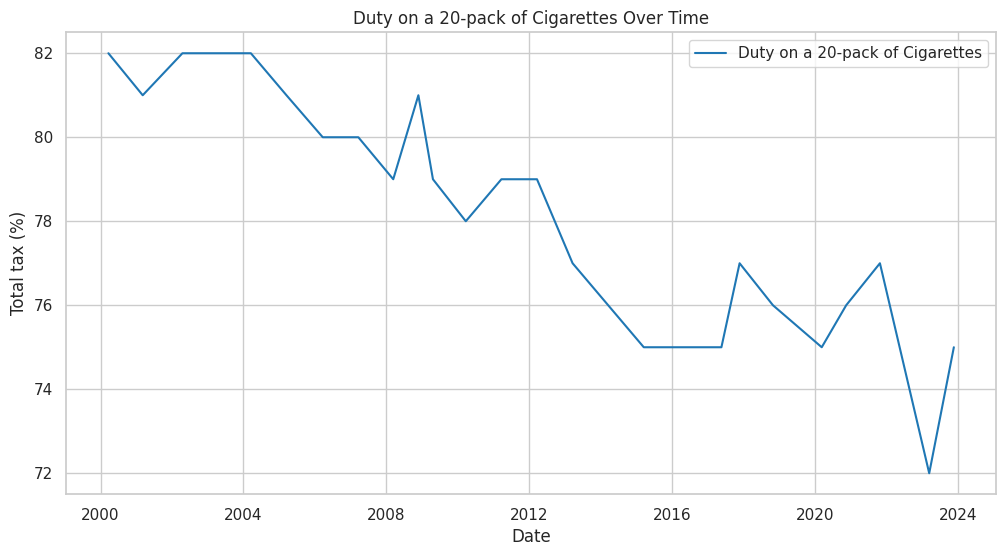

In [ ]:
# Plotting the duty over time
plt.figure(figsize=(12, 6))
plt.plot(combined_df['Date of change'], combined_df['Percentage tax'], label='Duty on a 20-pack of Cigarettes', color='tab:blue')
plt.xlabel('Date')
plt.ylabel('Total tax (%)')
plt.title('Duty on a 20-pack of Cigarettes Over Time')
plt.legend()
plt.grid(True)
plt.show()

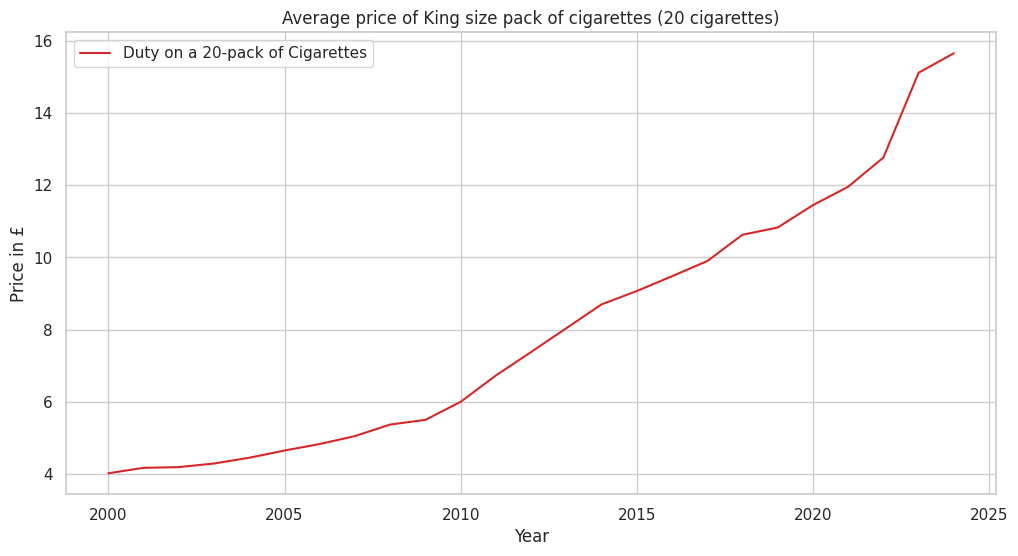

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(price['year'], price['Price in £'], label='Duty on a 20-pack of Cigarettes', color='tab:red')
plt.xlabel('Year')
plt.ylabel('Price in £')
plt.title('Average price of King size pack of cigarettes (20 cigarettes)')
plt.legend()
plt.grid(True)
plt.show()

### Analysis Four:  The effect of affordability of tobacco on smoking prevalence



To understand how this has impacted on the affordability of tobacco products, we then analysed NHS publicly available datasets on the affordability of tobacco in England to see how this increase in tax has impacted it.

#### Import NHS affordability of tobacco dataset

In [ ]:
import pandas as pd

afford_url = 'https://raw.githubusercontent.com/rhobaker/Data_Project/main/NHS_smoking_eng_2020/Table_S.3.1-Table_1_cleaned.csv'

affordability = pd.read_csv(afford_url)
affordability.drop(['Unnamed: 0'], axis=1, inplace=True)
#Getting relevant columns for visualisation
affordability=affordability[["Year","Tobacco Price Index", "Retail Price Index", "Tobacco Affordability Index"]]
#Further qualifying the data so only data from the years 2000 is selected
affordability_2000 = affordability.iloc[13:33]
affordability_2000.set_index("Year", inplace = True)
# affordability_2000

These numbers show that in the years from 2000 to 2019 the price of tobacco (the Tobacco Price Index) has increased by 190% ((786.1-270.4)/270.4).  In comparison, the price of other goods has only increased by 70% ((288.8-170.3)/170.3).  As a result tobacco has become 28% less affordable ((93.7-67.3)/93.7).

To analyse these numbers further, we have compared the affordability of tobacco to the smoking rate.

In [ ]:
#Getting relevant columns for visualisation
adults=smokers[["Year", "All 16+"]]
#Reversing the columns so that both datasets match
adults_reversed = adults.iloc[::-1]
adults_reversed
#Further qualifying the data so only data from the years 2000 is selected
adults_2000 = adults_reversed.iloc[13:33]
adults_2000 = adults_2000.reset_index()
adults_2000.drop(['index'], axis=1, inplace=True)
adults_2000.set_index("Year", inplace = True)
#adults_2000


In [ ]:
expend_url = 'https://raw.githubusercontent.com/rhobaker/Data_Project/main/NHS_smoking_eng_2020/Table_S.3.2-Table_1_cleaned.csv'
expenditure = pd.read_csv(expend_url)
expenditure.drop(['Unnamed: 0'], axis=1, inplace=True)
expenditure.set_index("Year", inplace = True)
expenditure

,Tobacco Expenditure,Total Expenditure,Tobacco Expenditure (%)
Year,,,
1987,"7,631","302,328",2.5
1988,"7,890","340,363",2.3
1989,"8,112","372,485",2.2
1990,"8,576","404,595",2.1
1991,"9,556","432,980",2.2
1992,"10,169","454,983",2.2
1993,"10,631","482,302",2.2
1994,"10,787","505,805",2.1
1995,"11,349","531,720",2.1


In [ ]:
# Merge datasets
merged_datasets = pd.DataFrame(pd.merge(adults_2000, affordability_2000, left_index=True, right_index=True, how='inner'))
merged_datasets.rename(columns={"All 16+": 'Smoking Rate'}, inplace=True)
merged_all_datasets = pd.DataFrame(pd.merge(merged_datasets, expenditure, left_index=True, right_index=True, how='inner'))

### Affordability and Proportion of Smokers

In [ ]:
#Correlation coefficient
smoke_rate_afford_corr = np.corrcoef(merged_datasets["Smoking Rate"], merged_datasets["Tobacco Affordability Index"])
smoke_rate_afford_corr

array([[1.        , 0.84144322],
       [0.84144322, 1.        ]])

There is a strong correlation between the affordability of tobacco and the smoking rate.  As tobacco becomes less affordable, the smoking rate decreases.

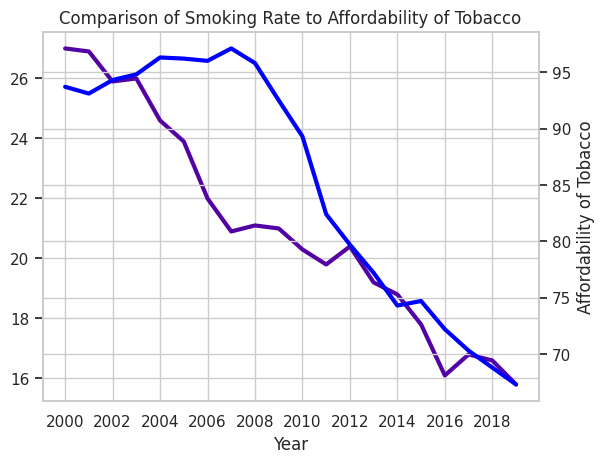

<Figure size 640x480 with 0 Axes>

In [ ]:
#Create a visualisation to compare the proportion of cigarette smokers vs the affordability of tobacco
sns.set_theme(style="whitegrid", palette="plasma")
fig, ax10 = plt.subplots()
plt.title("Comparison of Smoking Rate to Affordability of Tobacco")
ax10.set_xlabel("Year")
# Plot smoking rate
plt.plot(merged_all_datasets['Smoking Rate'], lw=3)

ax10.set_ylabel = "Proportion of cigarette smokers (%)"
ax10.tick_params(axis='y')
plt.xticks([2000,2002,2004,2006,2008,2010,2012,2014,2016,2018])

# Adding Twin Axes to plot smoking rates
ax11 = ax10.twinx()
ax11.set_ylabel("Affordability of Tobacco")
plt.plot(merged_all_datasets['Tobacco Affordability Index'], lw=3, color="blue")
ax11.tick_params(axis='y')

# Show plot
plt.show()
plt.clf()

To understand the impact on household expenditure, we also compared the smoking rate to the percentage of household expenditure spent on tobacco.

In [ ]:
#Correlation coefficient
smoke_rate_exp_corr = np.corrcoef(merged_all_datasets["Smoking Rate"], merged_all_datasets["Tobacco Expenditure (%)"])
smoke_rate_exp_corr

array([[1.        , 0.88856459],
       [0.88856459, 1.        ]])

This also shows a clear correlation between the percentage of household expenditure and the declining smoking rate, even as the price of cigarettes increases significantly more than the retail price index.

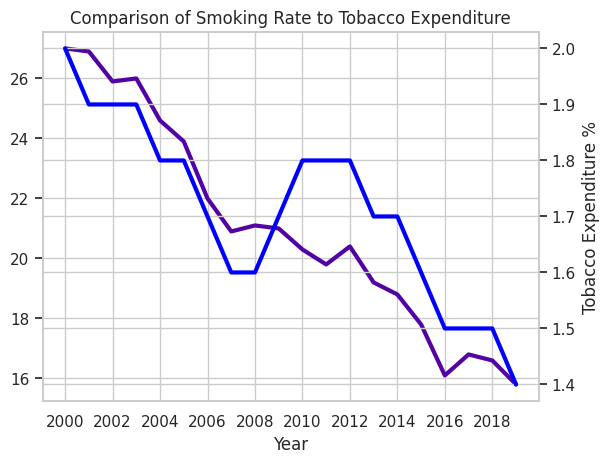

<Figure size 640x480 with 0 Axes>

In [ ]:
#Create a visualisation to compare the proportion of cigarette smokers vs the expenditure on tobacco
sns.set_theme(style="whitegrid", palette="plasma")
fig, ax10 = plt.subplots()
plt.title("Comparison of Smoking Rate to Tobacco Expenditure")
ax10.set_xlabel("Year")
# Plot smoking rate
plt.plot(merged_all_datasets['Smoking Rate'], lw=3)

ax10.set_ylabel = "Proportion of cigarette smokers (%)"
ax10.tick_params(axis='y')
plt.xticks([2000,2002,2004,2006,2008,2010,2012,2014,2016,2018])

# Adding Twin Axes to plot smoking rates
ax11 = ax10.twinx()
ax11.set_ylabel("Tobacco Expenditure %")
plt.plot(merged_all_datasets['Tobacco Expenditure (%)'], lw=3, color="blue")
ax11.tick_params(axis='y')

# Show plot
plt.show()
plt.clf()

The proportion of cigarette smokers has generally decreased at a relatively steady rate, while the afforability of tobacco is more volatile as it responds to external economic factors.

Interestingly, we can see that the proportion of cigarette smokers has slightly increased in 2002, 2007 and 2011. This would seem counterintuitive with the 2007 indoor smoking ban - perhaps a response due to the heightened visibility of smoking in the media?

## Conclusions

+ A relatively steady decline in the proportion of smokers in the UK can be seen dating back to the 1980s.
+ The affordability of tobacco has decreased since the 1980s but is somewhat more volatile and appears to respond to external economic factors. In cases where tobacco is relatively affordable, there is no comparable increase or more limited reduction in the proportion of smokers.
+ Household expenditure on tobacco does not reduce at the same rate as the proportion in smokers. We can in fact see an increase in tobacco expenditure from 2008 - 2010, co-inciding with the "credit crunch" and recession in 2008 and 2009, despite both the continued reduction of the number of smokers and a sharp drop in tobacco affordability. This suggests that reducing the affordability of tobacco is of limited effectiveness as a measure to reduce the amount of tobacco consumed by those who are pre-existing smokers.
+ Increasing the price of tobacco is potentially most effective as a deterrant to prevent people from taking up smoking as a habit. It is of limited effectiveness as a tool to help people quit smoking.

## Analysis Five: Changes in e-cigarette use

The proposed ban focuses on reducing smoking rates, but also acknowledges the issue of the use of e-cigarettes (a.k.a. vaping). E-cigarettes don't contain tobacco, the key factor causing cancer, they are not risk-free. Although their use is important tool for a less harmful alternative to smoking and tool for quitting, there are concerns of the rate rising to a concerning level, particularly in young people. The NHS recommends that young people should not take up vaping, concerned that vape 'flavours' such as fruit and sweets are more attractive to young people. The long-term side-effects of vaping are still unknown.

We analysed e-cigarette rates using ONS datasets, looking at different age group demographics.  

#### E-cigarette use by age category


In [ ]:
#Import vaping dataset
url = ("https://raw.githubusercontent.com/rhobaker/Data_Project/main/ONS_ecigarette_use_in_great_britain/table1abc_cleaned.csv")

vapers = pd.read_csv(url)

vapers.drop(['Unnamed: 0'], axis=1, inplace=True)

# vapers.head()

In [ ]:
#Vapers by age category
vapers_ages = vapers[["Year", "All 16-24", "All 25-34", "All 35-49", "All 50-59", "All 60+"]]

#Rename columns for better labels in vis
columns = ['Year', '16-24', '25-34', '35-49', '50-59', '60+']
vapers_ages.columns = columns

#Convert data to long format for seaborn visualisation
v_ages_melt = pd.melt(vapers_ages, id_vars="Year")
v_ages_melt.head()

#Clean up long table
v_ages_melt.rename(columns={"variable": "Age_group", "value": "Proportion"}, inplace=True)
# v_ages_melt.head()

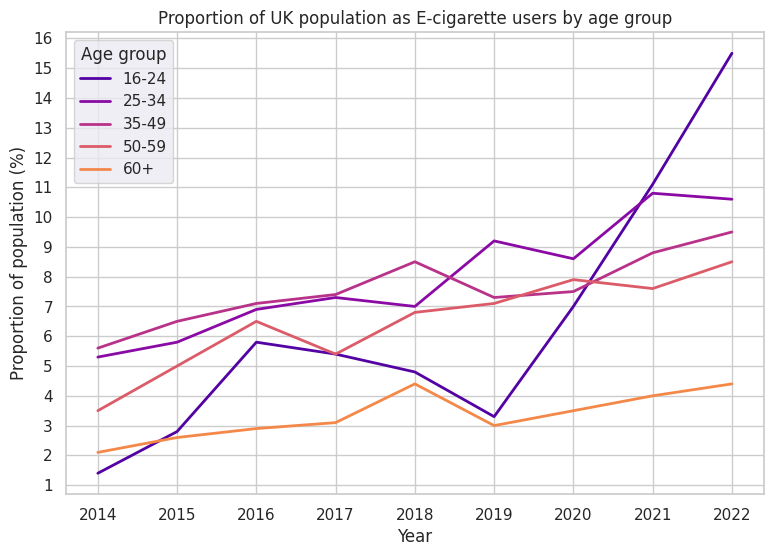

<Figure size 640x480 with 0 Axes>

In [ ]:
#Multi-line plot on e-cig use over time by age group
plt.figure(figsize=(9, 6))
ax = sns.lineplot(x='Year', y='Proportion', hue='Age_group', data=v_ages_melt, lw=2)

ax.set(xlabel='Year',
       ylabel='Proportion of population (%)',
       title='Proportion of UK population as E-cigarette users by age group',)

ax.set_yticks(range(1,17))
ax.set_yticklabels(range(1,17))

sns.set_style("darkgrid")

plt.legend(title='Age group')
plt.show()
plt.clf()

We can see that in all age groups, the e-cigarette usage rate has been increasing over time. Analysing by age group, we can see that:
- Ages 35-59 increase steadily
- Ages 25-34 increases more quickly over time
- Ages 60+ doesn't show much growth, showing that vaping is much less popular with the older generation.
- Post 2019 we can see a dramatic increase in the 16-24 age group; where previously this demographic had a lower use than most of the other age categories, there is an extreme growth in the rate.  

Let's compare e-cigarette rates to smoking rates between age groups to see if there are any patterns, taking a snapshot from the most recent year in the data (2022):

#### E-cigarette vs smoking prevalence by age category

In [ ]:
#Extract smokers ages
smokers_ages = smokers[['All 16-24', 'All 25-34', 'All 35-49', 'All 50-59', 'All 60+']]
#Rename columns for better labels in later vis
columns = ['16-24', '25-34', '35-49', '50-59', '60+']
smokers_ages.columns = columns
#Extract just 2022 smokers
smoke22 = smokers_ages.loc[0].to_frame()
#Clean up dataframe
smoke22.insert(0, 'Type', 'Smokers')
smoke22 = smoke22.reset_index()
smoke22.rename(columns={"index": "Age_group", 0: "Proportion"}, inplace=True)
# smoke22.head()

#Extract just 2022 vapers
vape22 = vapers_ages.loc[0].to_frame()
#Clean up dataframe
vape22.insert(0, 'Type', 'Vapers')
vape22 = vape22.reset_index()
vape22.rename(columns={"index": "Age_group", 0: "Proportion"}, inplace=True)
vape22 = vape22.drop(0, axis='index')
# vape22.head()

#Combine vaper and smoker dfs
combined22 = pd.concat([smoke22, vape22], ignore_index=True)
# combined22.head()

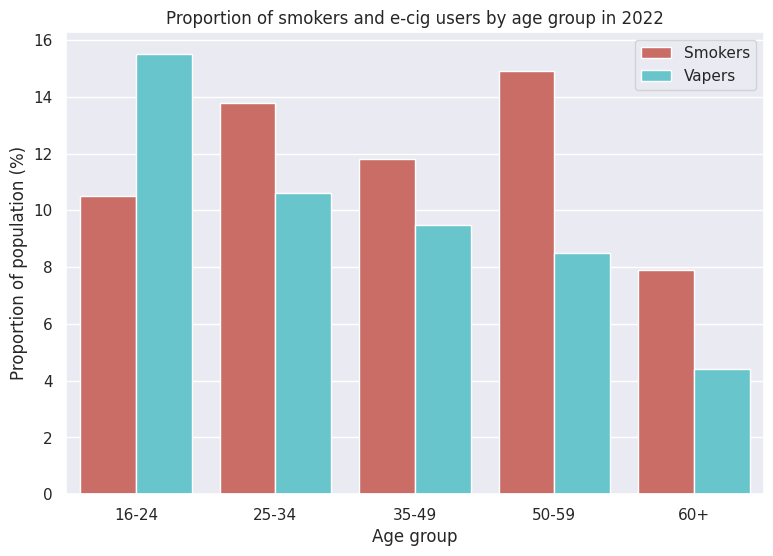

<Figure size 640x480 with 0 Axes>

In [ ]:
#Bar plot of smoking and e-cig use by age group in 2022

plt.figure(figsize=(9, 6))
ax = sns.barplot(combined22, x="Age_group", y="Proportion", hue="Type", palette='hls')

ax.set(xlabel='Age group',
       ylabel='Proportion of population (%)',
       title='Proportion of smokers and e-cig users by age group in 2022',)

ax.legend_.set_title(None)
plt.show()
plt.clf()

Here we can see that smoking rates do not have a clear correlation to vaping rates between age groups. Smoking rates vary between age groups, but vaping has a clear trend of higher use the younger the age group. Therefore younger people are likely to have a higher usage because of the attractiveness of vaping, not just as a tool to quit smoking as their smoking rates are lower than most of the other age groups.

#### E-cigarette device type in youths 17 and under

One of the key concerns in recent years is the rise in disposable vapes, particularly their use by young people. The UK government plans to ban these as part of the proposed bill, with Scotland having a confirmed date of banning disposable vapes from 1 April 2025. Although we do not have a recent dataset to be able to analyse general e-cigarette rates in young people under 17, we can reliably extract a small amount of data from the Ash smokefree GB youth survey report to look at device type use in this age category.

In [ ]:
#Import e-cig device type data
url = ("https://raw.githubusercontent.com/rhobaker/Data_Project/main/ONS_ecigarette_use_in_great_britain/Most_freq_used_e-cig_by_device_type_gb_youth.csv")
disposable = pd.read_csv(url)
# disposable.head()

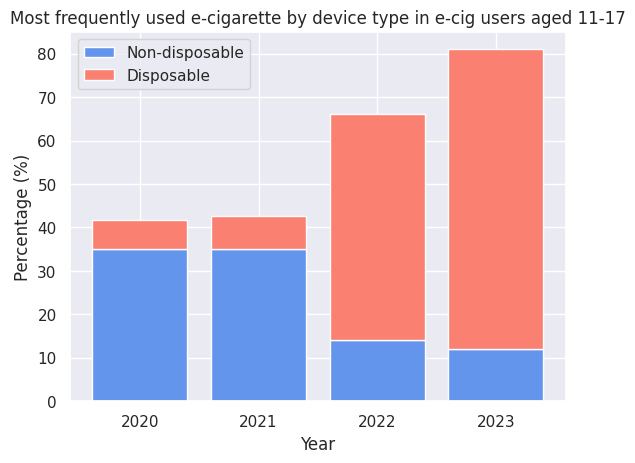

<Figure size 640x480 with 0 Axes>

In [ ]:
#Stacked bar plot for e-cig use by device

x = disposable['Year']
y1 = disposable['Non-disposable']
y2 = disposable['Disposable']

plt.bar(x, y1, color='cornflowerblue')
plt.bar(x, y2, bottom=y1, color='salmon')

plt.xticks([2020, 2021, 2022, 2023])
plt.legend([])

plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.title("Most frequently used e-cigarette by device type in e-cig users aged 11-17")
plt.legend(['Non-disposable', 'Disposable'])
plt.show()
plt.clf()

#### Conclusion

Although evidence shows that government mitigations are effective in bringing down smoking rates, the rise in e-cigarette use is a concern. A steady rise in use as expected as smoking rates decrease and e-cigarettes are used as quitting tools or less harmful alternatives to smoking. However the very sharp increase of e-cigarette use in younger people is far above the expected rate, considerably higher than the recent smoking rate in this demographic. Government mitigations on vaping should therefore be focussed on young people; without mitigations the rate of vaping in young people could rise exponentially.

The planned ban on disposable vapes is likely to reduce the e-cigarette usage rate in young people, with an overwhelming majority of those 11-17 using disposable vapes most frequently, although this will also benefit other age groups. The UK government have stated that alongside banning disposable vapes, measures will be brought forward to to restrict vape flavours, displays and packaging, to make them less attractive to children. Our MPOWER analysis shows that government mitigations effectively reduced smoking rates by including measures on displays and advertising, therefore this ban is likely to be effective and curb the rise in the vaping rate in young people by introducing restrictions in these areas, particularly as vaping flavours and colours are more attractive to younger people.

## Analysis Five - Identify non-government intervention factors that may impact on smoking rates

Although smoking rates correlate with factors such as affordability and e-cigarette use that the government may have some control over, smoking rates are also potentially influenced by other factors.

To identify these we analysed the changes in smoking habits from 2014 to 2022, to determine if other factors could be influencing the rates.

The first variable we looked at was to see if there were any differences between smoking rates for people with different levels of education.


In [49]:
# Load the CSV file
url = ("https://raw.githubusercontent.com/rhobaker/Data_Project/main/ONS_smoking_habits_in_the_uk_and_its_constituent_countries/Table_9.csv")

data = pd.read_csv(url)

# Display the first few rows to understand its structure
# data

In [52]:
# Clean the column names
data.columns = data.columns.str.replace('\n', ' ').str.replace(' ', '_').str.replace('__', '_').str.strip()
# print(data.columns.tolist())
['Country_code', 'Country', 'Highest_level_of_education', '2022_Current_smokers_%', '2022_Current_smokers_LCL', '2022_Current_smokers_UCL', '2022_Ex-smokers_%', '2022_Ex-smokers_LCL', '2022_Ex-smokers_UCL', '2022_Never_smoked_%', '2022_Never_smoked_LCL', '2022_Never_smoked_UCL', '2022__Weighted_count_[note_2]', '2022_Sample_size_[note_3]', '2021_Current_smokers_%', '2021_Current_smokers_LCL', '2021_Current_smokers_UCL', '2021_Ex-smokers_%', '2021_Ex-smokers_LCL', '2021_Ex-smokers_UCL', '2021_Never_smoked_%', '2021_Never_smoked_LCL', '2021_Never_smoked_UCL', '2021__Weighted_count_[note_2]', '2021_Sample_size_[note_3]', '2020_Current_smokers_%', '2020_Current_smokers_LCL', '2020_Current_smokers_UCL', '2020_Ex-smokers_%', '2020_Ex-smokers_LCL', '2020_Ex-smokers_UCL', '2020_Never_smoked_%', '2020_Never_smoked_LCL', '2020_Never_smoked_UCL', '2020_Weighted_count_[note_2]', '2020_Sample_size_[note_3]', '2019_Current_smokers_%', '2019_Current_smokers_LCL', '2019_Current_smokers_UCL', '2019_Ex-smokers_%', '2019_Ex-smokers_LCL', '2019_Ex-smokers_UCL', '2019_Never_smoked_%', '2019_Never_smoked_LCL', '2019_Never_smoked_UCL', '2019_Weighted_count_[note_2]', '2019_Sample_size_[note_3]', '2018_Current_smokers_%', '2018_Current_smokers_LCL', '2018_Current_smokers_UCL', '2018_Ex-smokers_%', '2018_Ex-smokers_LCL', '2018_Ex-smokers_UCL', '2018_Never_smoked_%', '2018_Never_smoked_LCL', '2018_Never_smoked_UCL', '2018_Weighted_count_[note_2]', '2018_Sample_size_[note_3]', '2017_Current_smokers_%', '2017_Current_smokers_LCL', '2017_Current_smokers_UCL', '2017_Ex-smokers_%', '2017_Ex-smokers_LCL', '2017_Ex-smokers_UCL', '2017_Never_smoked_%', '2017_Never_smoked_LCL', '2017_Never_smoked_UCL', '2017_Weighted_count_[note_2]', '2017_Sample_size_[note_3]', '2016_Current_smokers_%', '2016_Current_smokers_LCL', '2016_Current_smokers_UCL', '2016_Ex-smokers_%', '2016_Ex-smokers_LCL', '2016_Ex-smokers_UCL', '2016_Never_smoked_%', '2016_Never_smoked_LCL', '2016_Never_smoked_UCL', '2016_Weighted_count_[note_2]', '2016_Sample_size_[note_3]', '2015_Current_smokers_%', '2015_Current_smokers_LCL', '2015_Current_smokers_UCL', '2015_Ex-smokers_%', '2015_Ex-smokers_LCL', '2015_Ex-smokers_UCL', '2015_Never_smoked_%', '2015_Never_smoked_LCL', '2015_Never_smoked_UCL', '2015_Weighted_count_[note_2]', '2015_Sample_size_[note_3]', '2014_Current_smokers_%', '2014_Current_smokers_LCL', '2014_Current_smokers_UCL', '2014_Ex-smokers_%', '2014_Ex-smokers_LCL', '2014_Ex-smokers_UCL', '2014_Never_smoked_%', '2014_Never_smoked_LCL', '2014_Never_smoked_UCL', '2014_Weighted_count_[note_2]', '2014_Sample_size_[note_3]']
# Adjusted column names based on the inspection
columns_of_interest = [
    'Country', 'Highest_level_of_education',
    '2022_Current_smokers_%', '2022_Current_smokers_LCL', '2022_Current_smokers_UCL',
    '2022_Ex-smokers_%', '2022_Ex-smokers_LCL', '2022_Ex-smokers_UCL',
    '2022_Never_smoked_%', '2022_Never_smoked_LCL', '2022_Never_smoked_UCL'
]

# Select relevant columns for the year 2022
data_2022 = data[columns_of_interest].copy()
# data_2022

In [54]:

# Convert percentage columns to numeric
percentage_columns = [
    '2022_Current_smokers_%', '2022_Current_smokers_LCL', '2022_Current_smokers_UCL',
    '2022_Ex-smokers_%', '2022_Ex-smokers_LCL', '2022_Ex-smokers_UCL',
    '2022_Never_smoked_%', '2022_Never_smoked_LCL', '2022_Never_smoked_UCL'
]

#for col in percentage_columns:
data_2022[col] = pd.to_numeric(data_2022[col], errors='coerce')

# Check for missing data
missing_data_summary = data_2022.isnull().sum()
# print(missing_data_summary)
data_2022 = data_2022[data_2022.Country.isin(["United Kingdom"])]
# data_2022

In [55]:
data_to_merge = pd.DataFrame(data_2022[["Highest_level_of_education",'2022_Current_smokers_%']])
data_to_merge.set_index(["Highest_level_of_education"], inplace = True)
levels_data = {
  "Highest_level_of_education": ["Degree or equivalent", "Higher education", "GCE A level or equivalent", "GCSE grades A*-C or equivalent", "Other qualification", "No qualifications"],
  "Total Population Percentage": [21,9,22,21,12,14]
}
levels_df = pd.DataFrame(levels_data)
levels_df.set_index(["Highest_level_of_education"], inplace = True)
merged_qual_data = pd.merge(levels_df, data_to_merge, left_index=True, right_index=True, how='outer' )
# merged_qual_data

In [64]:
#Correlation coefficient
# smokers_young_arr = np.array(smokers['All 16-24'].loc[:8])
# vapers_young_arr = np.array(vapers['All 16-24'].loc[:8])

ed_level_coeff = np.corrcoef(merged_qual_data["Total Population Percentage"], merged_qual_data["2022_Current_smokers_%"])
#smoke_vape_young_coeff

>> Quick check of education rates online:
Degree: 21
HEd: 9
A level: 22
GCSE: 21
Other: 12
None: 14
>> Plotted them together to make sure that there was a difference based on level of education and it wasn't just mirroring the population as a whole.
>> String negative correlation, so worth doing this analysis properly.
>> Data from:
https://www.ons.gov.uk/peoplepopulationandcommunity/educationandchildcare/adhocs/10516highestlevelofqualificationachievedbypeoplelivinginukregions2010to2018

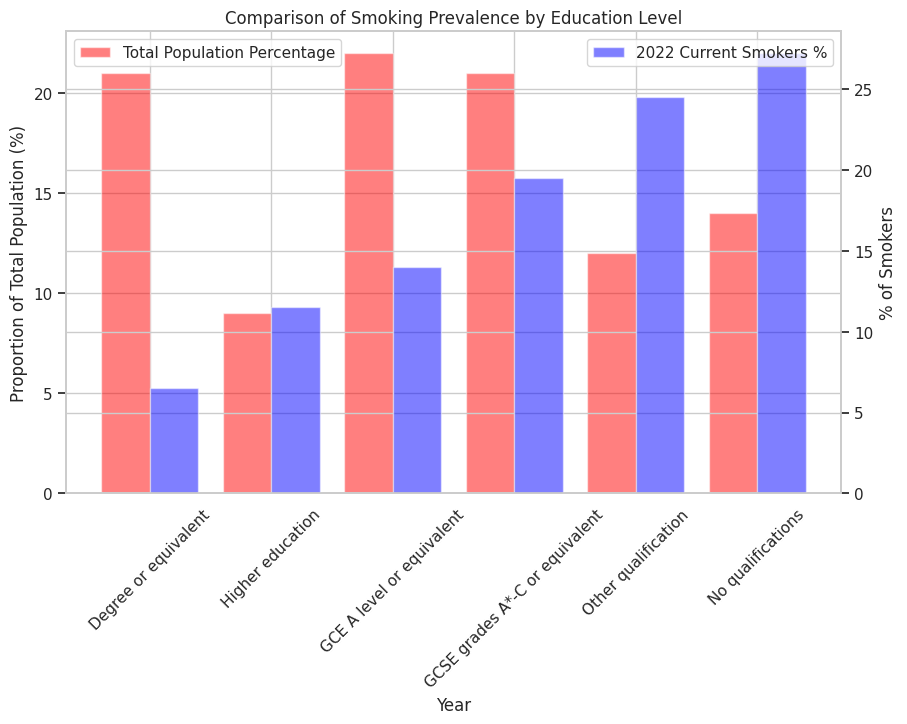

In [65]:
#Create a visualisation to compare the proportion of cigarette smokers vs the expenditure on tobacco
# Set the theme
sns.set_theme(style="whitegrid")

# Create a figure and axis
fig, ax10 = plt.subplots(figsize=(10, 6))

# Title
plt.title("Comparison of Smoking Prevalence by Education Level")

# X-axis label
ax10.set_xlabel("Year")

# Plot the proportion of the total population
bar_width = 0.4
index = merged_qual_data.index.tolist()

# Primary y-axis: Proportion of the total population
ax10.bar(index, merged_qual_data['Total Population Percentage'], bar_width, color="red", alpha=0.5, label="Total Population Percentage")
ax10.set_ylabel("Proportion of Total Population (%)")
ax10.tick_params(axis='y')

# Secondary y-axis: Smoking rates
ax11 = ax10.twinx()
ax11.bar([i + bar_width for i in range(len(index))], merged_qual_data['2022_Current_smokers_%'], bar_width, color="blue", alpha=0.5, label="2022 Current Smokers %")
ax11.set_ylabel("% of Smokers")
ax11.tick_params(axis='y')

# Adjusting the x-ticks to be in the center
ax10.set_xticks([i + bar_width / 2 for i in range(len(index))])
ax10.set_xticklabels(index, rotation=45)

# Adding legends
ax10.legend(loc='upper left')
ax11.legend(loc='upper right')

# Show plot
plt.show()
plt.clf()

In [66]:
# Convert percentage columns to numeric
percentage_columns = [
    '2022_Current_smokers_%', '2022_Current_smokers_LCL', '2022_Current_smokers_UCL',
    '2022_Ex-smokers_%', '2022_Ex-smokers_LCL', '2022_Ex-smokers_UCL',
    '2022_Never_smoked_%', '2022_Never_smoked_LCL', '2022_Never_smoked_UCL'
]

for col in percentage_columns:
    data_2022[col] = pd.to_numeric(data_2022[col], errors='coerce')

# Check for missing data
missing_data_summary = data_2022.isnull().sum()
#print(missing_data_summary)

In [69]:
# Display the cleaned column names
# print(data.columns.tolist())

# Extract the years present in the dataset based on column names
years = list(set([col.split('_')[0] for col in data.columns if col.split('_')[0].isdigit()]))
# print("Years found in the dataset:", years)

# List of smoking status categories
smoking_statuses = ['Current_smokers_%', 'Ex-smokers_%', 'Never_smoked_%']

# Correct column names for melting
columns_to_melt = {}
for status in smoking_statuses:
    columns_to_melt[status] = [col for col in data.columns if status in col]

# print("Columns to melt for each status:", columns_to_melt)

# Initialize an empty list to store dataframes
dfs = []

# Loop through each smoking status to melt the data
for status, status_cols in columns_to_melt.items():
    status_df = data.melt(id_vars=['Country', 'Highest_level_of_education'],
                          value_vars=status_cols,
                          var_name='Year_Status',
                          value_name=status)

    # Extract year from the combined Year_Status column
    status_df['Year'] = status_df['Year_Status'].str.extract('(\d{4})').astype(int)

    # Drop the Year_Status column
    status_df = status_df.drop(columns=['Year_Status'])

    # Append the melted dataframe to the list
    dfs.append(status_df)

# Merge the dataframes on common columns
data_long = dfs[0]
for df in dfs[1:]:
    data_long = pd.merge(data_long, df, on=['Country', 'Highest_level_of_education', 'Year'])

#print(data_long.head())

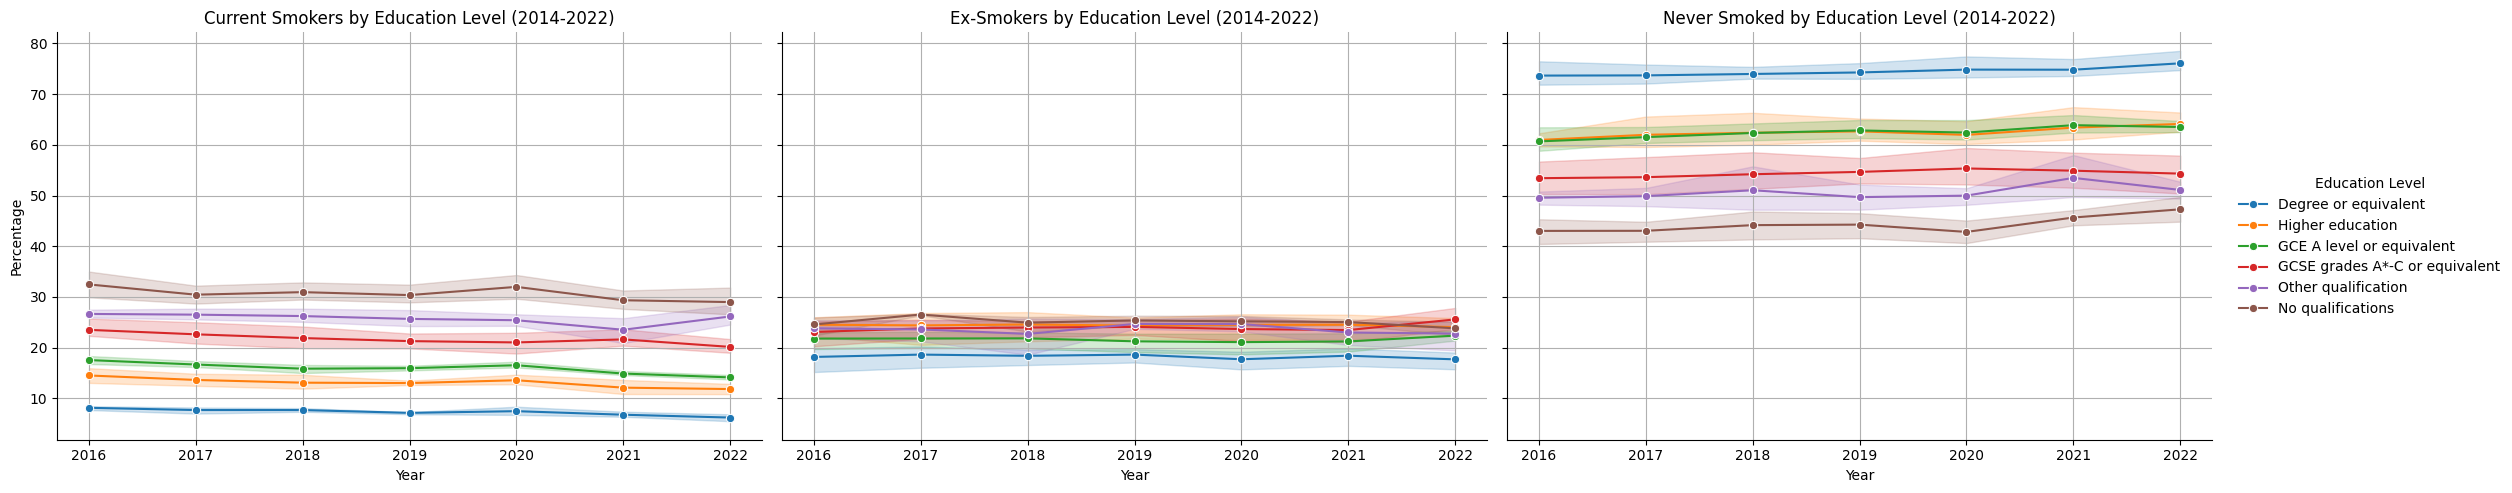

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data to include only years from 2016 to 2022
data_filtered = data_long[data_long['Year'].between(2016, 2022)]

# Prepare the data for facet grid
data_long_melted = data_filtered.melt(
    id_vars=['Year', 'Highest_level_of_education'],
    value_vars=smoking_statuses,
    var_name='Smoking_Category',
    value_name='Percentage'
)

# Create a facet grid for the smoking categories
g = sns.FacetGrid(data_long_melted, col='Smoking_Category', hue='Highest_level_of_education', col_order=smoking_statuses, height=5, aspect=1.5)
g.map(sns.lineplot, 'Year', 'Percentage', marker='o')
g.add_legend(title='Education Level')

# Set the titles for each facet
facet_titles = {
    'Current_smokers_%': 'Current Smokers by Education Level (2014-2022)',
    'Ex-smokers_%': 'Ex-Smokers by Education Level (2014-2022)',
    'Never_smoked_%': 'Never Smoked by Education Level (2014-2022)'
}

# Enable grid lines and set titles
for ax in g.axes.flat:
    ax.grid(True)  # Enable grid lines
    title_key = ax.get_title().split('=')[1].strip()
    ax.set_title(facet_titles.get(title_key, title_key))

plt.show()
plt.clf()

Conclusion of Smoking Habits by Education Level

**1. Current Smokers by Education Level**


- Individuals with lower educational attainment tend to have higher smoking rates. This could be due to a variety of socio-economic factors, including limited access to health education and resources.
Conversely, those with higher education levels generally show higher education often correlates with greater health awareness and healthier lifestyles.

**2. Ex-Smokers by Education Level**


- Generally, individuals with higher educational attainment are more likely to have quit smoking. This might reflect better access to smoking cessation programs and greater health literacy.
Lower education levels show a smaller percentage of ex-smokers, suggesting challenges in quitting smoking, possibly due to socio-economic factors and limited access to support resources.

**3. Never Smoked by Education Level**

- The percentage of individuals who have never smoked generally mirrors the trend observed in current smokers, with higher rates in those with higher education levels.

**To summarise:**

- The three charts collectively highlight the impact of education on smoking behaviours. These patterns underscore the importance of education as a determinant of health behaviours and suggest that public health interventions aiming to reduce smoking prevalence may benefit from focusing on educational initiatives and targeted support for lower education groups.

- Addressing socio-economic disparities and enhancing access to health education and smoking cessation resources could further help in reducing smoking rates across all education levels.


**Insights for the future:**

Effectiveness of Public Health Efforts:

- The overall decline in current smoking rates and the increase in ex-smokers indicate that public health efforts are making a positive impact. However, the persistent disparities between education levels highlight the need for more targeted interventions.

Preventive Measures:

- Emphasising preventive measures in education, particularly in lower education groups, could help reduce the initiation of smoking. This includes integrating comprehensive smoking prevention programs into school curriculum and community outreach initiatives.

### QUESTION ONE - CONCLUSIONS:

Our analysis set out to answer the question:


**How effective does historic data suggest that government mitigations have been on affecting smoking prevalence?**


Firstly, we determined that global smoking rates reduced from 28.1% in 2007 to 20.9% in 2022 and that this strongly correlated to government intervention measures increasing over the same period.

When then focused our analysis on the UK to see if it followed this global trend. We saw a similar movement in smoking rates, reducing from 27.0% in 2000 to 15.6% in 2019.  This can be seen to link with government intervention measures around packaging and advertising becoming more stringent.

Our analysis of the tax paid on a packet of cigarettes shows that...

As tax has significantly increased the price of cigarettes, we can see that the affordability of tobacco has decreased.  This strongly correlates with the decrease in smoking rates and from this we can infer that decreasing the affordability of tobacco by increasing taxes is linked to a reduction in the overall smoking rate.

We then looked at the impact of e-cigarettes on changes in the overall tobacco smoking rate as anecdotal evidence and our own personal experiences suggest that there has been a significant increase in e-cigarette use in the past few years.

Our analysis shows that as e-cigarette use has increased, the smoking rate has decreased, however the spike in e-cigarette use is disproportionally due to the younger generation, therefore how much impact this is having on overall smoking rates is harder to determine.

Finally we examined the available data to see if other socio-economic factors could be influencing the drop in smoking rate, outside of direct government control.

We could see that there was a clear link between education level and smoking rates; the higher the education level someone has the less likely they are to smoke.  *As education levels have been increasing over recent years this is likely to have had an influence on smoking rates decreasing.*

When we did a similar analysis for differences between smoking rates in men and women we could not see any similar trends, so we concluded that any future government interventions should equally consider both men and women when their implmentation is planned.

The evidence therefore suggests that smoking rates will continue to fall if the future government, elected in the July 2024 UK general election, continues to tighten legislation and increase tax in a similar way to previous ones.  Socio-economic trends influencing e-cigarette use and education levels may also impact this reduction.


## Question Two: Based on this analysis, how effective will the new ban be on reducing smoking prevalence?



## Predicting future smoking rates

Using our historic data on overall smoking prevalence rates from the ONS, we can use machine learning to implement a simple linear regression model. We don't have the advanced techniques to fully evaluate our model, but the linear regression will give us a rough estimation of future smoking rates based on the current trends and mitigations.

In [ ]:
#Some re-formatting of previous dfs
adults_2000 = adults.loc[0:22]
adults_2000.rename(columns={"All 16+": "Smoking Rate"}, inplace=True)
# adults_2000.head()

<ipython-input-204-4eeb9b017014>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adults_2000.rename(columns={"All 16+": "Smoking Rate"}, inplace=True)


In [ ]:
#Selecting variables
x = adults_2000['Year'] #independent variable
y = adults_2000['Smoking Rate'] #dependent variable
# Test scatter of variables
# plt.scatter(x,y)

In [ ]:
#sklearn needs a 2D array to work, not 1D
#Reshape variables to 2D

x = np.array(x).reshape(-1,1)
y = np.array(y).reshape(-1,1)

In [ ]:
#Split data for training and testing
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [ ]:
#Create model and train the model with training sets
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [ ]:
#Briefly evaluate model's performance

#Get the R^2 value, which describes how well the linear regression model fits the data points, the closer to 1 the better.
print(model.score(x_test,y_test))

# > 0.9, strong R^2 score.

0.9184764364800353


In [ ]:
#Use testing set to create predictions
y_pred = model.predict(x_test)

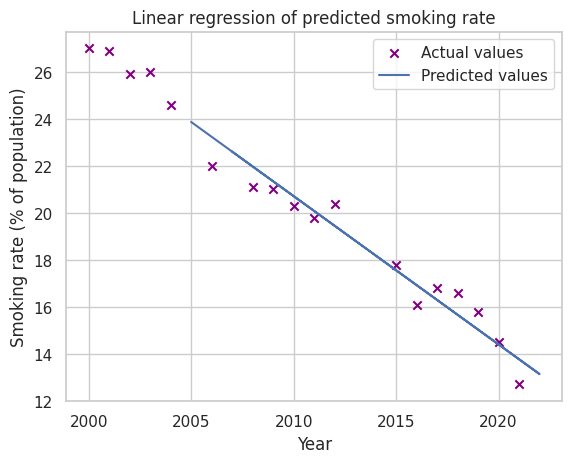

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plot the linear regression
plt.scatter(x_train, y_train,color='purple', marker="x", label="Actual values")
plt.plot(x_test, y_pred,color='b', label="Predicted values")
plt.xlabel("Year")
plt.ylabel("Smoking rate (% of population)")
plt.title("Linear regression of predicted smoking rate")
plt.legend()
plt.show()
plt.clf()

In [ ]:
#We can see that our algorithm is working correctly. We can now input values to the model to make predictions.#

#Create a function to input a year and get a predicted smoking rate from the model:

def rate_predict(year):
    #Convert year to 2D array
    arr = np.array(year).reshape(-1,1)
    #Predict the y value (smoking rate)
    pred_year = model.predict(arr)
    return print(f"The predicted smoking rate in {year} is {pred_year[0][0]:.2f}%")

In [ ]:
#Call the function:

rate_predict(2030)
rate_predict(2035)

The predicted smoking rate in 2030 is 8.09%
The predicted smoking rate in 2035 is 4.93%


####Conclusion:

The government's target smoking rate is to be 'smokefree' by 2030, with an overall smokinng prevalence of 5% or less. Our model roughly predicts that without any further mitigations, the smoking rate would be at 8% by 2030. With the proposed smoking ban to be enacted in 2027, it is a realistic estimation, based on looking at effects of past mitigations on the rate of decrease in the smoking rate, that the ban would cause at least an extra 1% decrease in the rate per year from 2020, allowing the goverment to reach its 'smokefree' goal by 2030.